# Impact of Feature Scaling on Neural Network Performance – Heart Disease Classification

### 1. Objective
**Goal:** Build and evaluate a neural network model on the Heart Disease dataset, focusing on the effects of different preprocessing techniques such as feature scaling, normalization, and categorical encoding.

### 2. Load the Dataset

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


### 3. Data Exploration & Preprocessing

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [3]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [4]:
# Check class distribution
df['target'].value_counts(normalize=True)

target
1    0.513171
0    0.486829
Name: proportion, dtype: float64

In [5]:
# Check categorical and numerical columns
categorical_cols = ['cp', 'restecg', 'slope', 'thal', 'sex', 'fbs', 'exang', 'ca']

In [6]:
numerical_cols = [col for col in df.columns if col not in categorical_cols + ['target']]

### 4. Train-Test Split

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### 5. Preprocessing Variants
Three versions of the dataset:
- Raw (no scaling)
- Normalized (MinMaxScaler)
- Standardized (StandardScaler)

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Helper: Apply one-hot encoding to categorical columns
def preprocess_data(X, scaler=None):
    ct = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', scaler, numerical_cols)
    ])
    X_transformed = ct.fit_transform(X)
    return X_transformed

# Preprocessing pipelines
X_train_raw = pd.get_dummies(X_train)  # Raw: One-hot encode only
X_test_raw = pd.get_dummies(X_test)

X_train_norm = preprocess_data(X_train, MinMaxScaler())
X_test_norm = preprocess_data(X_test, MinMaxScaler())

X_train_std = preprocess_data(X_train, StandardScaler())
X_test_std = preprocess_data(X_test, StandardScaler())

### 6. Build Neural Network Model

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score

def build_compile_model(input_dim, learning_rate=0.001):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

### Train Models – Raw vs Normalized vs Standardized

In [10]:
from keras.callbacks import EarlyStopping

def train_and_evaluate(X_train, X_test, y_train, y_test, variant_name):
    model = build_compile_model(X_train.shape[1])
    es = EarlyStopping(patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                        validation_split=0.1,
                        epochs=100,
                        batch_size=32,
                        callbacks=[es],
                        verbose=0)
    
    # Evaluate
    y_pred = (model.predict(X_test) > 0.5).astype('int32')
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    print(f"\n--- {variant_name} ---")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")
    
    return history

history_raw = train_and_evaluate(X_train_raw, X_test_raw, y_train, y_test, "Raw")
history_norm = train_and_evaluate(X_train_norm, X_test_norm, y_train, y_test, "Normalized (MinMax)")
history_std = train_and_evaluate(X_train_std, X_test_std, y_train, y_test, "Standardized (StandardScaler)")

C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

--- Raw ---
Accuracy: 0.8439, Precision: 0.8174, Recall: 0.8952


C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

--- Normalized (MinMax) ---
Accuracy: 0.9854, Precision: 0.9811, Recall: 0.9905


C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

--- Standardized (StandardScaler) ---
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


### 8. Plot Loss Curves

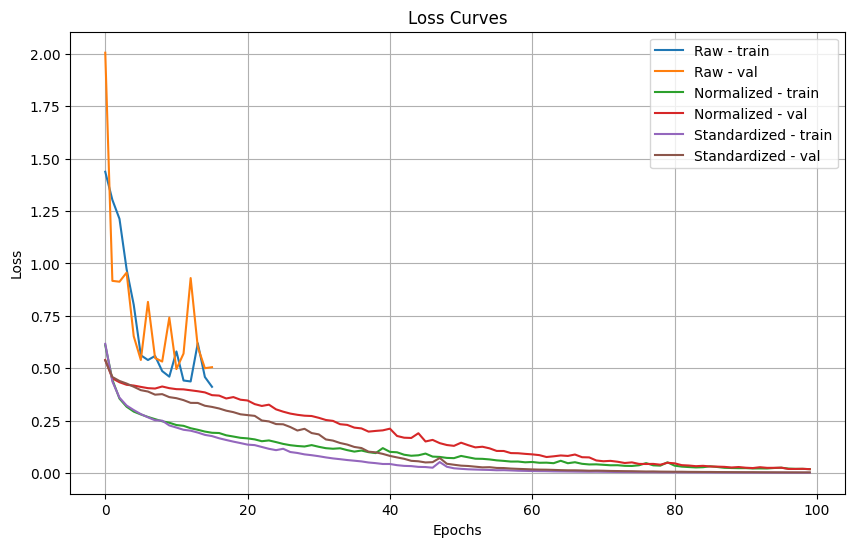

In [11]:
import matplotlib.pyplot as plt

def plot_history(history, label):
    plt.plot(history.history['loss'], label=f"{label} - train")
    plt.plot(history.history['val_loss'], label=f"{label} - val")

plt.figure(figsize=(10, 6))
plot_history(history_raw, "Raw")
plot_history(history_norm, "Normalized")
plot_history(history_std, "Standardized")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### 9. Learning Rate Sensitivity Test

In [12]:
# Try different learning rates for one setup (e.g., standardized)
for lr in [0.01, 0.001, 0.0001]:
    print(f"\nTesting with learning rate = {lr}")
    _ = train_and_evaluate(X_train_std, X_test_std, y_train, y_test, f"Standardized - LR={lr}")


Testing with learning rate = 0.01


C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

--- Standardized - LR=0.01 ---
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Testing with learning rate = 0.001


C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

--- Standardized - LR=0.001 ---
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Testing with learning rate = 0.0001


C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

--- Standardized - LR=0.0001 ---
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000
